In [376]:
import matplotlib.pyplot as plt
from tifffile import imshow
import numpy as np
from tqdm import tqdm

In [377]:
from functools import wraps
from time import time
def measure(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            print(f"Total execution time: {end_ if end_ > 0 else 0} ms")
    return _time_it

In [378]:
im_num = 9
image = plt.imread('data/{}.jpg'.format(im_num))
image = image / 255.

0.054901960784313725

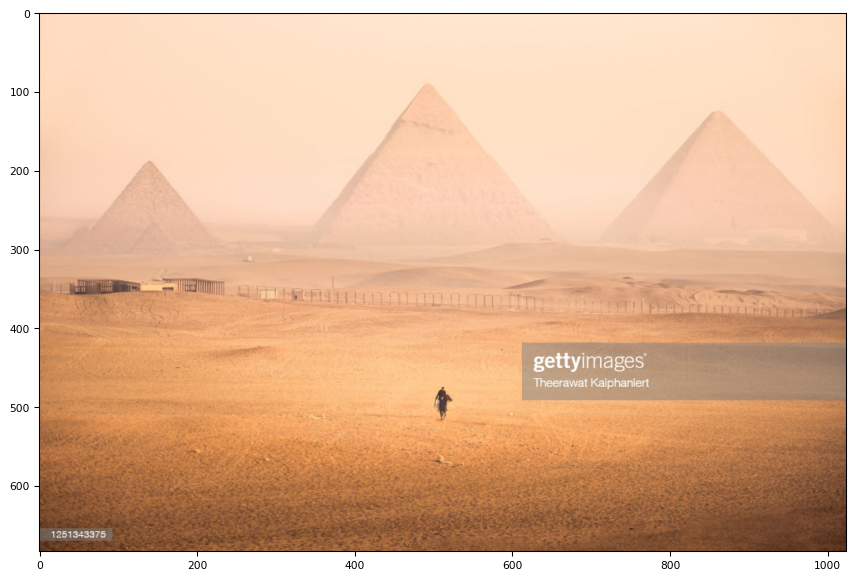

In [379]:
imshow(image)
image.min()

In [380]:
@measure
def dark_channel_prior(img, patch_size=15):
    dark_prior = np.zeros(img.shape[0:2])
    pad = patch_size // 2
    # img = skimage.util.pad(img, (pad, pad), mode='edge')
    for i in tqdm(range(dark_prior.shape[0])):
        for j in range(dark_prior.shape[1]):
            # print(img[max(i - pad, 0): min(i + pad, img.shape[0]), max(j - pad, 0): min(j + pad, img.shape[1])].shape)
            dark_prior[i, j] = np.min(img[max(i - pad, 0): min(i + pad, img.shape[0]), max(j - pad, 0): min(j + pad, img.shape[1])])
    return dark_prior

In [381]:
@measure
def dark_channel_prior_fast(img, patch_size=15):
    dark_prior = np.zeros(img.shape[0:2])
    img = np.min(img, axis=-1)
    pad = patch_size // 2
    forward = np.zeros(img.shape[1])
    backward = np.zeros(img.shape[1])
    step = patch_size - 1
    for i in range(img.shape[0]):
        for j in range(0, img.shape[1], step):
            cur_min = 1.
            for k in range(step):
                if j + k >= img.shape[1]:
                    break
                new_min = img[i, j + k]
                if new_min < cur_min:
                    cur_min = new_min
                forward[j + k] = cur_min
            cur_min = 1.
            for k in range(step - 1, -1, -1):
                if j + k >= img.shape[1]:
                    continue
                new_min = img[i, j + k]
                if new_min < cur_min:
                    cur_min = new_min
                backward[j + k] = cur_min
        for j in range(img.shape[1]):
            dark_prior[i, j] = min(forward[min(j + pad, img.shape[1] - 1)], backward[max(j - pad, 0)])

    forward = np.zeros(img.shape[0])
    backward = np.zeros(img.shape[0])
    for j in range(img.shape[1]):
        for i in range(0, img.shape[0], step):
            cur_min = 1.
            for k in range(step):
                if i + k >= img.shape[0]:
                    break
                new_min = dark_prior[i + k, j]
                if new_min < cur_min:
                    cur_min = new_min
                forward[i + k] = cur_min
            cur_min = 1.
            # print('a')
            for k in range(step - 1, -1, -1):
                if i + k >= img.shape[0]:
                    # print(j + k)
                    continue
                # print('a')
                new_min = dark_prior[i + k, j]
                if new_min < cur_min:
                    cur_min = new_min
                backward[i + k] = cur_min

        for i in range(img.shape[0]):
            dark_prior[i, j] = min(forward[min(i + pad, img.shape[0] - 1)], backward[max(i - pad, 0)])
    return dark_prior

In [382]:
@measure
def dark_channel_prior_faster(img, patch_size=15):
    dark_prior = np.min(img, axis=-1)
    pad = patch_size // 2
    forward = np.zeros(dark_prior.shape[:2])
    backward = np.zeros(dark_prior.shape[:2])
    step = patch_size - 1
    forward[:, :step] = np.minimum.accumulate(dark_prior[:, :step], axis=1)
    backward[:, step - 1:: -1] = np.minimum.accumulate(dark_prior[:, step - 1:: -1], axis=1)
    for j in range(step, img.shape[1], step):
        forward[:, j: j + step] = np.minimum.accumulate(dark_prior[:, j: j + step], axis=1)
        backward[:, j + step - 1: j - 1: -1] = np.minimum.accumulate(dark_prior[:, j + step - 1: j - 1: -1], axis=1)
    forward = np.pad(forward, (0, pad), 'constant', constant_values=1)[:-pad, pad:]
    backward = np.pad(backward, (pad, 0), 'constant', constant_values=1)[pad:, :-pad]
    dark_prior = np.minimum(forward, backward)

    forward = np.zeros(dark_prior.shape[:2])
    backward = np.zeros(dark_prior.shape[:2])
    step = patch_size - 1
    forward[:step] = np.minimum.accumulate(dark_prior[:step], axis=0)
    backward[step - 1:: -1] = np.minimum.accumulate(dark_prior[step - 1:: -1], axis=0)
    for j in range(step, img.shape[1], step):
        forward[j: j + step] = np.minimum.accumulate(dark_prior[j: j + step], axis=0)
        backward[j + step - 1: j - 1: -1] = np.minimum.accumulate(dark_prior[j + step - 1: j - 1: -1], axis=0)
    forward = np.pad(forward, (0, pad), 'constant', constant_values=1)[pad:, :-pad]
    backward = np.pad(backward, (pad, 0), 'constant', constant_values=1)[:-pad, pad:]
    dark_prior = np.minimum(forward, backward)

    return dark_prior

In [383]:
# Реализация guided filter основана на https://github.com/swehrwein/python-guided-filter
def window(img, r):
    (rows, cols) = img.shape[:2]
    im_dst = np.zeros(img.shape)

    tile = [1] * img.ndim
    tile[0] = r
    im_cum = np.cumsum(img, 0)
    im_dst[0:r+1, :, ...] = im_cum[r:2*r+1, :, ...]
    im_dst[r+1:rows-r, :, ...] = im_cum[2*r+1:rows, :, ...] - im_cum[0:rows-2*r-1, :, ...]
    im_dst[rows-r:rows, :, ...] = np.tile(im_cum[rows-1:rows, :, ...], tile) - im_cum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    im_cum = np.cumsum(im_dst, 1)
    im_dst[:, 0:r+1, ...] = im_cum[:, r:2*r+1, ...]
    im_dst[:, r+1:cols-r, ...] = im_cum[:, 2*r+1 : cols, ...] - im_cum[:, 0 : cols-2*r-1, ...]
    im_dst[:, cols-r: cols, ...] = np.tile(im_cum[:, cols-1:cols, ...], tile) - im_cum[:, cols-2*r-1 : cols-r-1, ...]

    return im_dst

# def window2(img, r):
#     img = np.pad(img, (int((r - 1) / 2), 0), mode='edge')
#     img = np.pad(img, (0, int((r - 1) / 2)), mode='constant', constant_values=0)
#     img = np.add.accumulate(img, axis=1)
#     img = img - np.pad(img, ((0, 0), (r, 0)))[:, :-r]
#     img[:,-2 * (r - 1) :-r + 1]  -= img[:,:-r:-1]
#     img = np.add.accumulate(img, axis=0)
#     img = img - np.pad(img, ((r, 0), (0, 0)))[:-r, :]
#     img[-2 * (r - 1) :-r + 1]  -= img[:-r:-1]
#     return img[r-1:-r + 1, r-1:-r + 1]


def guided_filter(I, p, r, eps):
    N = window(np.ones(I.shape), r)
    mean_I = window(I, r) / N
    mean_p = window(p, r) / N
    var_I = window(I ** 2, r) / N - mean_I ** 2
    a = (window(I * p, r) / N - mean_I * mean_p) / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = window(a, r) / N
    mean_b = window(b, r) / N

    q = mean_a * I + mean_b
    return q

In [384]:
dark_prior = dark_channel_prior_faster(image, 15)

Total execution time: 83 ms


In [385]:
mask = dark_prior > (np.quantile(dark_prior, q=0.999) - 0.001)
norm_factor = np.zeros(image.shape[-1])
image_normed = np.zeros(image.shape)
for i in range(image.shape[-1]):
    norm_factor[i] = np.max(image[..., i][mask])
    image_normed[..., i] = image[..., i] / norm_factor[i]

Total execution time: 102 ms


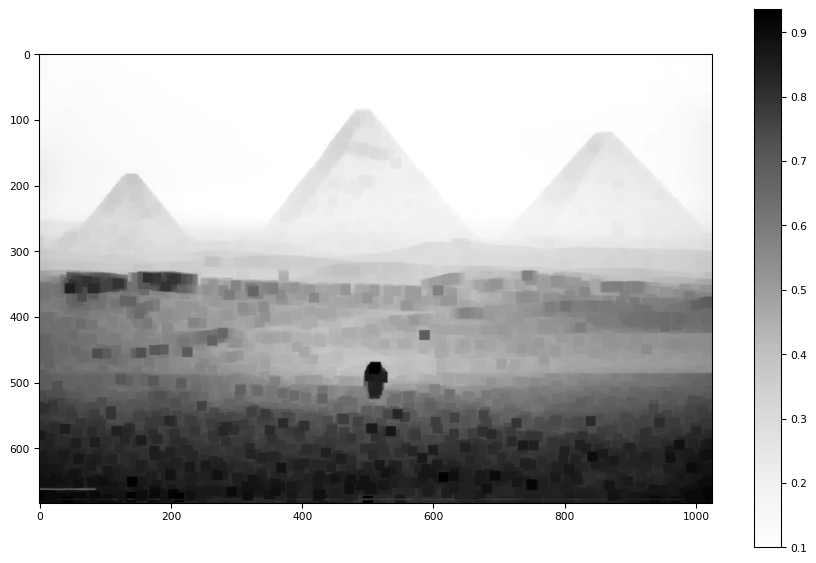

In [386]:
t_0 = 0.1
w = 0.95
t_wave = 1 - w * dark_channel_prior_faster(image_normed, 15)
mask = t_wave < t_0
t_wave[mask] = t_0
# t_wave = np.expand_dims(t_wave, -1)

imshow(t_wave, cmap='Greys')
plt.imsave('data/{}_t_wave.jpg'.format(im_num), t_wave, cmap='Greys')

In [387]:
image_normed_guidance = np.mean(image, -1)
# imshow(image_normed_guidance)

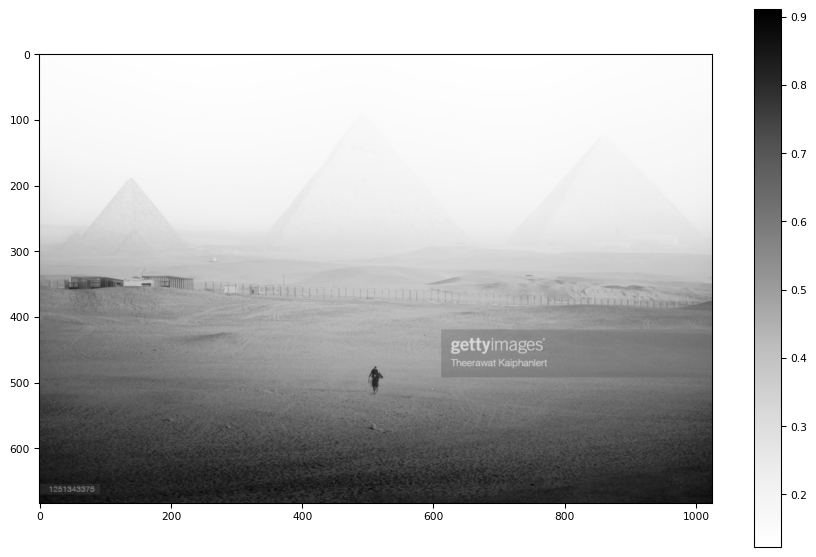

In [388]:
t = guided_filter(image_normed_guidance, t_wave, 150, 10**-2)
imshow(t, cmap='Greys')
plt.imsave('data/{}_t.jpg'.format(im_num), t, cmap='Greys')
t = np.expand_dims(t, -1)

In [389]:
# beta = 0.4
# data = np.log(t) / -beta
# imshow(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1bde3062040>)

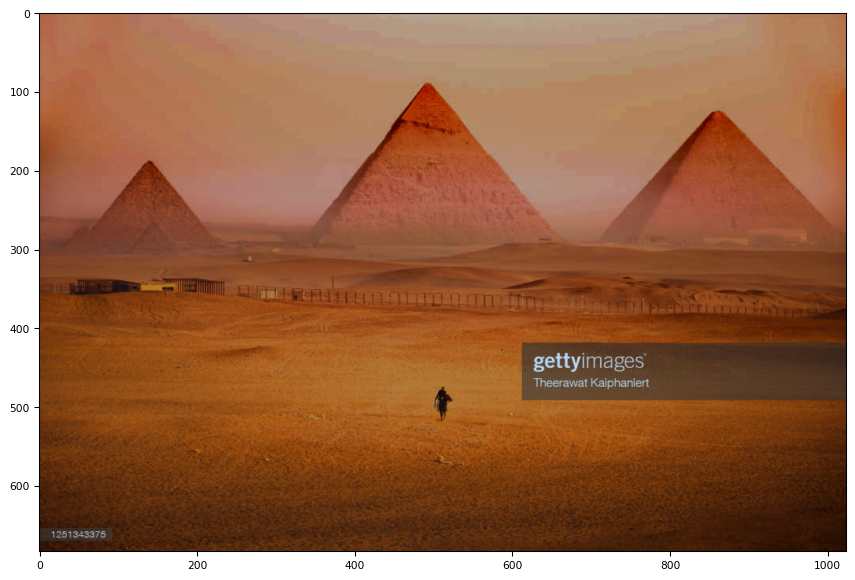

In [390]:
from sklearn.preprocessing import minmax_scale
refined_image = (image - norm_factor) / t + norm_factor
# for i in range(refined_image.shape[-1]):
#     refined_image[..., i] = (refined_image[..., i] - refined_image[..., i].min()) / (refined_image[..., i].max())
imshow(refined_image)

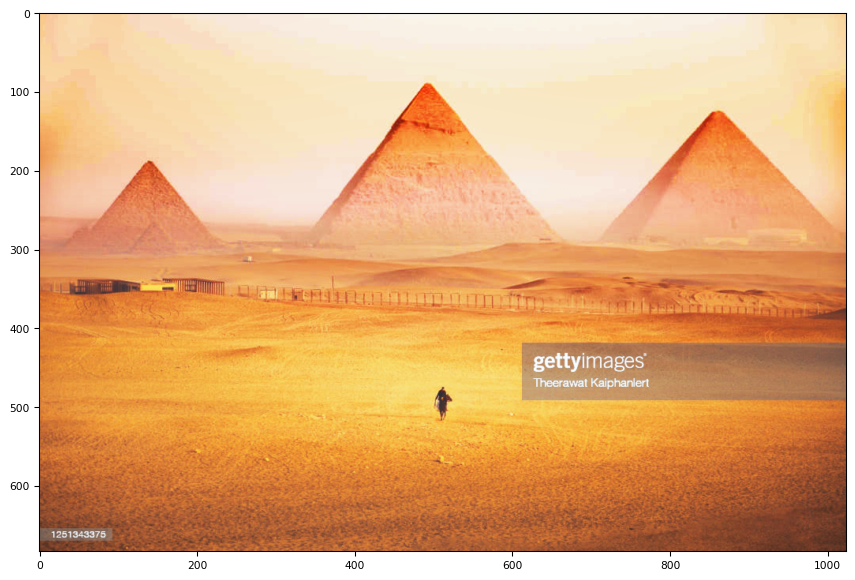

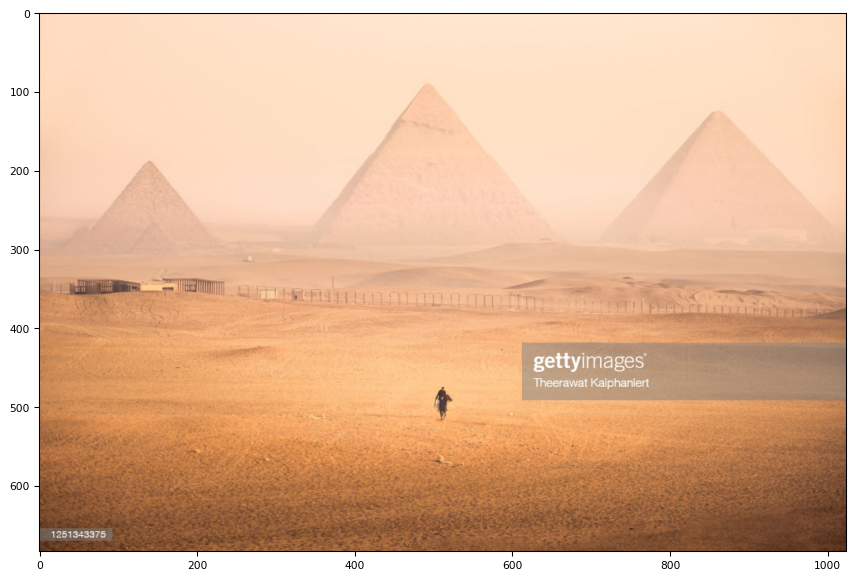

In [396]:
from skimage import exposure
refined_image2 = exposure.rescale_intensity(refined_image, out_range=(0,1))
# refined_image2 = exposure.adjust_gamma(refined_image2, 0.5)
refined_image2 = exposure.adjust_sigmoid(refined_image2, 0.4, 10)
# refined_image2 = exposure.equalize_adapthist(refined_image2)
imshow(refined_image2)
imshow(image)
plt.imsave('data/{}_refined.jpg'.format(im_num), refined_image2)

In [392]:
# refined_image2.min()